In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ovarian-dataset/Ovarian_pp.txt


In [2]:
import pandas as pd

# Load the txt file (adjust delimiter if needed)
df = pd.read_csv("/kaggle/input/ovarian-dataset/Ovarian_pp.txt", sep=',',header=None)  # or sep=' ' if space-delimited

# Save as CSV
df.to_csv("Ovarian_pp", index=False)

In [3]:
df = pd.read_csv("Ovarian_pp")
df.head()

,0,1,2,3,4,5,6,7,8,9,...,15145,15146,15147,15148,15149,15150,15151,15152,15153,15154
0,0.494626,0.263735,0.321841,0.220934,0.297622,0.316458,0.154763,0.223685,0.304346,0.241757,...,0.483622,0.449296,0.449296,0.449296,0.449296,0.449296,0.449296,0.449296,0.449296,2
1,0.258063,0.406593,0.321841,0.069771,0.333335,0.354432,0.321431,0.144740,0.260869,0.142853,...,0.631765,0.619718,0.619718,0.619718,0.619718,0.619718,0.619718,0.619718,0.619718,2
2,0.537636,0.032966,0.321841,0.209307,0.404762,0.113927,0.369049,0.223685,0.536231,0.131865,...,0.038462,0.035918,0.035918,0.035918,0.035918,0.035918,0.035918,0.035918,0.035918,2
3,0.000000,0.395605,0.310347,0.197673,0.404762,0.455701,0.416666,0.210527,0.420292,0.274723,...,0.497864,0.486621,0.486621,0.486621,0.486621,0.486621,0.486621,0.486621,0.486621,2
4,0.526884,0.395605,0.367817,0.383719,0.488099,0.392405,0.238094,0.500000,0.362316,0.274723,...,0.267096,0.251408,0.251408,0.251408,0.251408,0.251408,0.251408,0.251408,0.251408,2


In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

# -------------------------
# LOAD YOUR DATA
# -------------------------
# Assuming last column is target
df = pd.read_csv("Ovarian_pp")
data = df.values.astype(np.float32)

X = data[:, :-1]   # features
y = data[:, -1:]   # target (kept as column vector)

# Combine features + target for GAN training
data_with_target = np.hstack([X, y])
input_dim = data_with_target.shape[1]

# -------------------------
# HYPERPARAMETERS
# -------------------------
latent_dim = 100
batch_size = 32
n_critic = 5
lambda_gp = 10
epochs = 2000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# MODELS
# -------------------------
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, output_dim)
        )

    def forward(self, z):
        return self.model(z)


class Critic(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.model(x)


generator = Generator(latent_dim, input_dim).to(device)
critic = Critic(input_dim).to(device)

# -------------------------
# OPTIMIZERS
# -------------------------
optimizer_G = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.0, 0.9))
optimizer_C = optim.Adam(critic.parameters(), lr=1e-4, betas=(0.0, 0.9))

# -------------------------
# DATA LOADER
# -------------------------
tensor_data = torch.tensor(data_with_target, dtype=torch.float32)
loader = torch.utils.data.DataLoader(tensor_data, batch_size=batch_size, shuffle=True)

# -------------------------
# GRADIENT PENALTY
# -------------------------
def gradient_penalty(critic, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1).to(device)
    alpha = alpha.expand_as(real_samples)

    interpolates = alpha * real_samples + ((1 - alpha) * fake_samples)
    interpolates = interpolates.to(device)
    interpolates.requires_grad_(True)

    d_interpolates = critic(interpolates)
    fake = torch.ones(real_samples.size(0), 1).to(device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp

# -------------------------
# TRAINING LOOP
# -------------------------
for epoch in range(epochs):
    for i, real_samples in enumerate(loader):
        real_samples = real_samples.to(device)

        # ---------------------
        # Train Critic
        # ---------------------
        optimizer_C.zero_grad()

        z = torch.randn(real_samples.size(0), latent_dim).to(device)
        fake_samples = generator(z)

        real_validity = critic(real_samples)
        fake_validity = critic(fake_samples)

        gp = gradient_penalty(critic, real_samples, fake_samples)
        c_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp

        c_loss.backward()
        optimizer_C.step()

        # Train Generator every n_critic steps
        if i % n_critic == 0:
            optimizer_G.zero_grad()

            z = torch.randn(real_samples.size(0), latent_dim).to(device)
            fake_samples = generator(z)
            fake_validity = critic(fake_samples)

            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | C Loss: {c_loss.item():.4f} | G Loss: {g_loss.item():.4f} | GP: {gp.item():.4f}")

# -------------------------
# GENERATE SYNTHETIC DATA
# -------------------------
num_synthetic = 2000  # number of synthetic samples to create
z = torch.randn(num_synthetic, latent_dim).to(device)
synthetic_samples = generator(z).detach().cpu().numpy()

# Separate synthetic features & target
X_synth = synthetic_samples[:, :-1]
y_synth = synthetic_samples[:, -1:]

# Merge with original data
X_aug = np.vstack([X, X_synth])
y_aug = np.vstack([y, y_synth])

augmented_df = pd.DataFrame(np.hstack([X_aug, y_aug]), columns=df.columns)
augmented_df.to_csv("augmented_dataset.csv", index=False)

print("✅ Augmentation complete. Augmented dataset saved as 'augmented_dataset.csv'")


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [100/2000] | C Loss: -13.4054 | G Loss: 2.3444 | GP: 0.2573
Epoch [200/2000] | C Loss: -9.6589 | G Loss: 2.0168 | GP: 0.2116
Epoch [300/2000] | C Loss: -5.0135 | G Loss: 1.0052 | GP: 0.0810
Epoch [400/2000] | C Loss: -5.6754 | G Loss: 0.6761 | GP: 0.0918
Epoch [500/2000] | C Loss: -4.6475 | G Loss: 0.7385 | GP: 0.0376
Epoch [600/2000] | C Loss: -4.8728 | G Loss: 0.8905 | GP: 0.0589
Epoch [700/2000] | C Loss: -6.0319 | G Loss: -5.4198 | GP: 0.0460
Epoch [800/2000] | C Loss: -4.3714 | G Loss: 0.5681 | GP: 0.0599
Epoch [900/2000] | C Loss: -3.9050 | G Loss: 1.0797 | GP: 0.0502
Epoch [1000/2000] | C Loss: -4.2463 | G Loss: 2.5656 | GP: 0.0392
Epoch [1100/2000] | C Loss: -3.3164 | G Loss: -0.1045 | GP: 0.0329
Epoch [1200/2000] | C Loss: -3.1685 | G Loss: 5.5472 | GP: 0.0386
Epoch [1300/2000] | C Loss: -2.7852 | G Loss: 1.0115 | GP: 0.0245
Epoch [1400/2000] | C Loss: -2.2221 | G Loss: -9.5337 | GP: 0.0322
Epoch [1500/2000] | C Loss: -1.9727 | G Loss: -7.3235 | GP: 0.0245
Epoch [1600/20

In [5]:
augmented_df.shape

(2253, 15155)

In [6]:
for rows in range(2253):
    if augmented_df.iloc[rows,15154] < 1.5:
        augmented_df.iloc[rows,15154] = 1
    else:
        augmented_df.iloc[rows, 15154]= 2

In [7]:
augmented_df

,0,1,2,3,4,5,6,7,8,9,...,15145,15146,15147,15148,15149,15150,15151,15152,15153,15154
0,0.494626,0.263735,0.321841,0.220934,0.297622,0.316458,0.154763,0.223685,0.304346,0.241757,...,0.483622,0.449296,0.449296,0.449296,0.449296,0.449296,0.449296,0.449296,0.449296,2.0
1,0.258063,0.406593,0.321841,0.069771,0.333335,0.354432,0.321431,0.144740,0.260869,0.142853,...,0.631765,0.619718,0.619718,0.619718,0.619718,0.619718,0.619718,0.619718,0.619718,2.0
2,0.537636,0.032966,0.321841,0.209307,0.404762,0.113927,0.369049,0.223685,0.536231,0.131865,...,0.038462,0.035918,0.035918,0.035918,0.035918,0.035918,0.035918,0.035918,0.035918,2.0
3,0.000000,0.395605,0.310347,0.197673,0.404762,0.455701,0.416666,0.210527,0.420292,0.274723,...,0.497864,0.486621,0.486621,0.486621,0.486621,0.486621,0.486621,0.486621,0.486621,2.0
4,0.526884,0.395605,0.367817,0.383719,0.488099,0.392405,0.238094,0.500000,0.362316,0.274723,...,0.267096,0.251408,0.251408,0.251408,0.251408,0.251408,0.251408,0.251408,0.251408,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2248,0.568484,0.419503,0.409271,0.490253,0.484631,0.704075,0.452742,0.513235,0.675001,0.378199,...,0.518278,0.621594,0.728507,0.489900,0.522200,0.717054,0.515964,0.479664,0.490278,1.0
2249,0.521433,0.449284,0.338070,0.362817,0.404155,0.417871,0.316630,0.617034,0.330005,0.258559,...,0.513860,0.482539,0.640569,0.352518,0.494501,0.492576,0.460745,0.473024,0.622487,2.0
2250,0.462274,0.466111,0.436769,0.479609,0.475333,0.416827,0.528510,0.454848,0.426301,0.480309,...,0.304445,0.380866,0.414314,0.386675,0.312222,0.267972,0.366199,0.247471,0.338976,1.0
2251,0.606589,0.626450,0.420576,0.575381,0.575257,0.499630,0.470505,0.563339,0.560862,0.358729,...,0.525400,0.511269,0.490866,0.466510,0.451953,0.520919,0.464654,0.529996,0.503110,1.0


In [8]:
augmented_df.iloc[:,-1].unique()

array([2., 1.], dtype=float32)

In [9]:
(list(augmented_df.iloc[:,-1])).count(1.0)

1503

Average KL Divergence across features: 0.1114


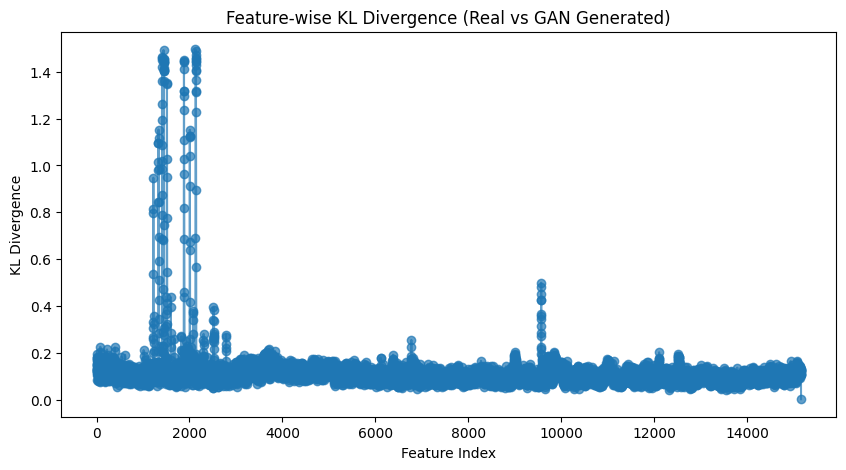

In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ----------------------------
# Assuming you already have:
#   data -> original dataset (pandas DataFrame)
#   augmented_df -> GAN generated dataset (pandas DataFrame)
# ----------------------------

def kl_divergence_featurewise(real_df, gen_df, bins=50):
    kl_values = []

    for col in range(real_df.shape[1]):  # iterate through each feature
        real_data = real_df.iloc[:, col].values
        gen_data = gen_df.iloc[:, col].values

        # Estimate histograms (distributions)
        real_hist, bin_edges = np.histogram(real_data, bins=bins, density=True)
        gen_hist, _ = np.histogram(gen_data, bins=bin_edges, density=True)

        # Convert to probabilities with small epsilon
        eps = 1e-10
        real_probs = torch.tensor(real_hist + eps, dtype=torch.float32)
        gen_probs = torch.tensor(gen_hist + eps, dtype=torch.float32)

        # Normalize to sum=1
        real_probs /= real_probs.sum()
        gen_probs /= gen_probs.sum()

        # KL divergence for this feature
        kl = F.kl_div(gen_probs.log(), real_probs, reduction='sum')
        kl_values.append(kl.item())

    return kl_values

# ----------------------------
# Run KL Divergence
# ----------------------------
kl_scores = kl_divergence_featurewise(df, augmented_df, bins=50)

print(f"Average KL Divergence across features: {np.mean(kl_scores):.4f}")

# ----------------------------
# Visualization
# ----------------------------
plt.figure(figsize=(10,5))
plt.plot(kl_scores, marker='o', alpha=0.7)
plt.xlabel("Feature Index")
plt.ylabel("KL Divergence")
plt.title("Feature-wise KL Divergence (Real vs GAN Generated)")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


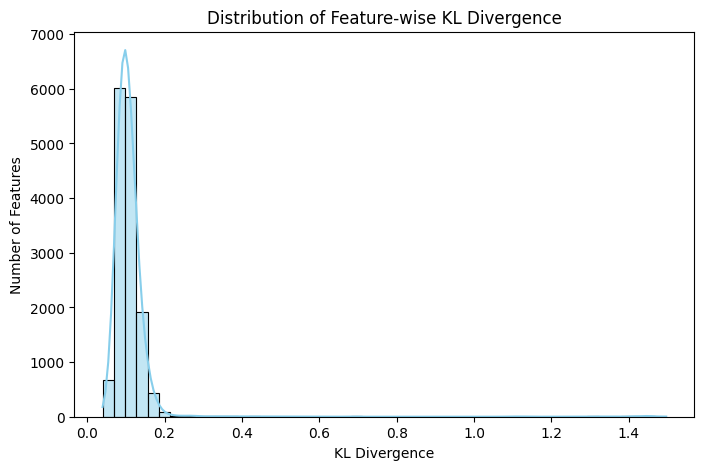

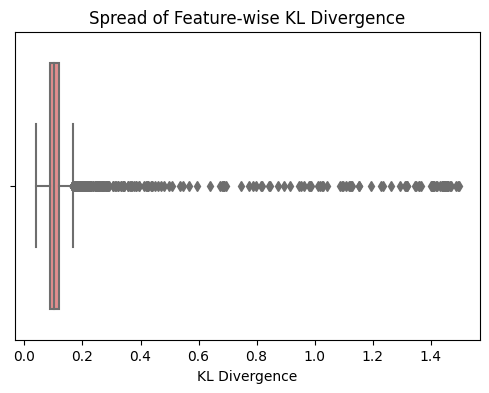

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


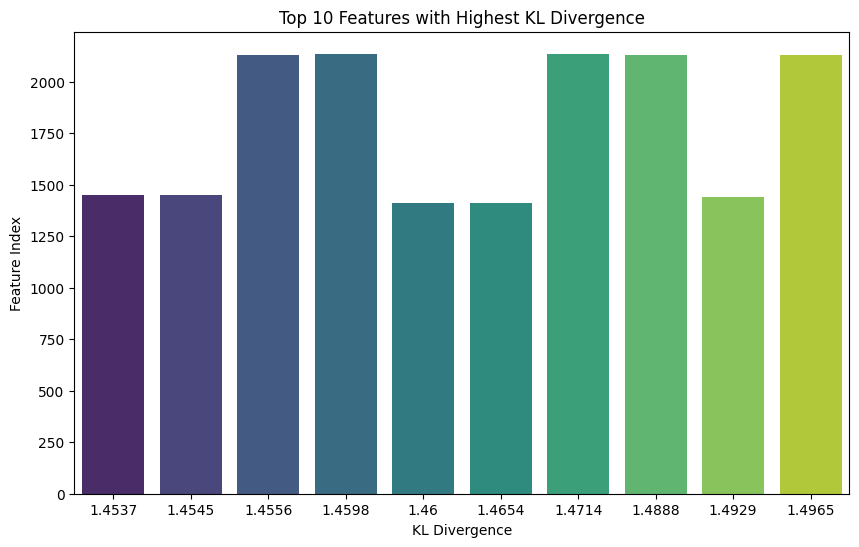

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Histogram of KL divergences
plt.figure(figsize=(8,5))
sns.histplot(kl_scores, bins=50, kde=True, color="skyblue")
plt.xlabel("KL Divergence")
plt.ylabel("Number of Features")
plt.title("Distribution of Feature-wise KL Divergence")
plt.show()

# Boxplot of KL divergences
plt.figure(figsize=(6,4))
sns.boxplot(x=kl_scores, color="lightcoral")
plt.xlabel("KL Divergence")
plt.title("Spread of Feature-wise KL Divergence")
plt.show()

# Top 20 features with highest KL
top_n = 10
top_indices = np.argsort(kl_scores)[-top_n:]
top_values = [round(kl_scores[i],4) for i in top_indices]

plt.figure(figsize=(10,6))
sns.barplot(x=top_values, y=top_indices, palette="viridis")
plt.xlabel("KL Divergence")
plt.ylabel("Feature Index")
plt.title(f"Top {top_n} Features with Highest KL Divergence")
plt.show()


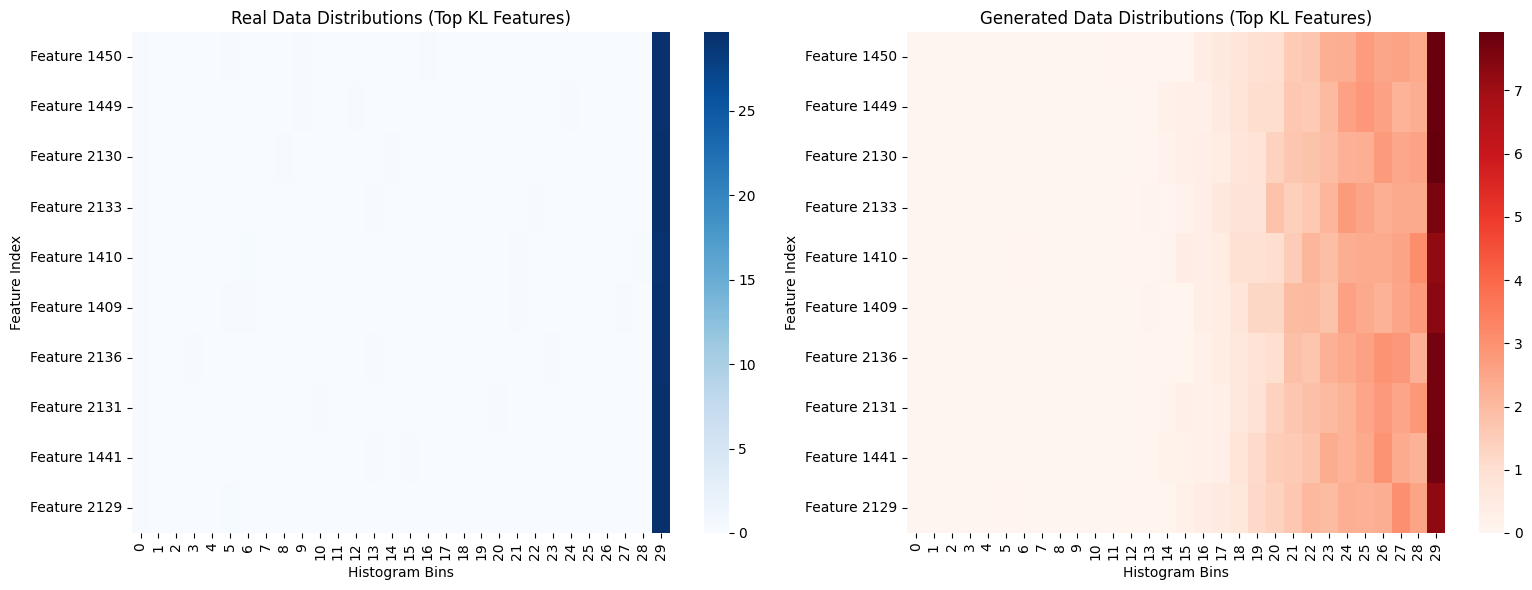

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

# -----------------------------
# Compute KL divergence per feature
# -----------------------------
def compute_kl_divergence(p, q, bins=50):
    p_hist, bin_edges = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bin_edges, density=True)

    p_hist = p_hist + 1e-10  # avoid 0
    q_hist = q_hist + 1e-10

    return entropy(p_hist, q_hist)

kl_scores = []
for i in range(df.shape[1]-1):  # iterate over features
    kl = compute_kl_divergence(df.iloc[:, i], augmented_df.iloc[:, i])
    kl_scores.append(kl)

kl_scores = np.array(kl_scores)

# -----------------------------
# Select top mismatched features
# -----------------------------
top_n = 10
top_indices = np.argsort(kl_scores)[-top_n:]

# -----------------------------
# Heatmap of distributions
# -----------------------------
real_dists = []
gen_dists = []
for i in top_indices:
    r_hist, bins = np.histogram(df.iloc[:, i], bins=30, density=True)
    g_hist, _ = np.histogram(augmented_df.iloc[:, i], bins=bins, density=True)

    real_dists.append(r_hist)
    gen_dists.append(g_hist)

# Convert to DataFrames for heatmap
real_df = pd.DataFrame(real_dists, index=[f"Feature {i}" for i in top_indices])
gen_df = pd.DataFrame(gen_dists, index=[f"Feature {i}" for i in top_indices])

# Plot heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(real_df, cmap="Blues", ax=axes[0], cbar=True)
axes[0].set_title("Real Data Distributions (Top KL Features)")
axes[0].set_xlabel("Histogram Bins")
axes[0].set_ylabel("Feature Index")

sns.heatmap(gen_df, cmap="Reds", ax=axes[1], cbar=True)
axes[1].set_title("Generated Data Distributions (Top KL Features)")
axes[1].set_xlabel("Histogram Bins")
axes[1].set_ylabel("Feature Index")

plt.tight_layout()
plt.show()


KL Divergence (Real || GAN): 0.0016


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


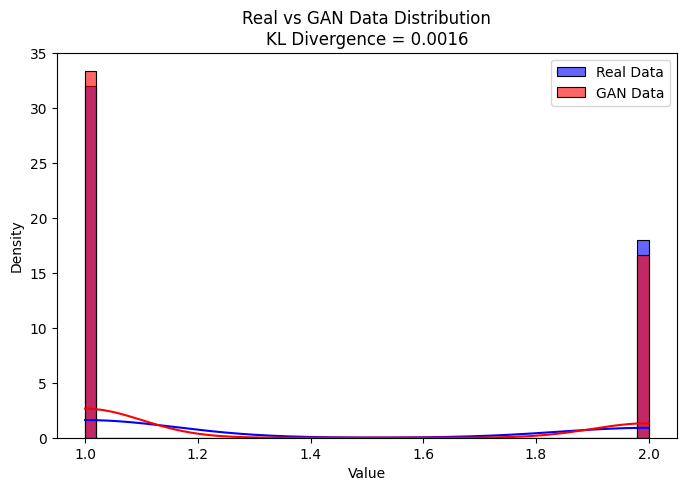

In [13]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# Example: Replace these with your real datasets
# ----------------------------
# Original dataset (1D features for simplicity)
real_data = df.iloc[:,-1]

# GAN generated dataset
gan_data = augmented_df.iloc[:,-1]
# ----------------------------
# Step 1: Estimate probability distributions
# ----------------------------
bins = 50  # number of bins for histogram
real_hist, bin_edges = np.histogram(real_data, bins=bins, density=True)
gan_hist, _ = np.histogram(gan_data, bins=bin_edges, density=True)

# To avoid log(0), add small epsilon
eps = 1e-10
real_probs = torch.tensor(real_hist + eps, dtype=torch.float32)
gan_probs = torch.tensor(gan_hist + eps, dtype=torch.float32)

# Normalize (make sure sum=1)
real_probs /= real_probs.sum()
gan_probs /= gan_probs.sum()

# ----------------------------
# Step 2: KL Divergence calculation
# ----------------------------
kl_div = F.kl_div(gan_probs.log(), real_probs, reduction='sum')  # D_KL(real || gan)
print(f"KL Divergence (Real || GAN): {kl_div.item():.4f}")

# ----------------------------
# Step 3: Visualization
# ----------------------------
plt.figure(figsize=(8,5))
sns.histplot(real_data, bins=bins, stat="density", color="blue", label="Real Data", kde=True, alpha=0.6)
sns.histplot(gan_data, bins=bins, stat="density", color="red", label="GAN Data", kde=True, alpha=0.6)

plt.title(f"Real vs GAN Data Distribution\nKL Divergence = {kl_div.item():.4f}")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


2025-08-19 05:31:38.069425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755581498.266977      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755581498.332433      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


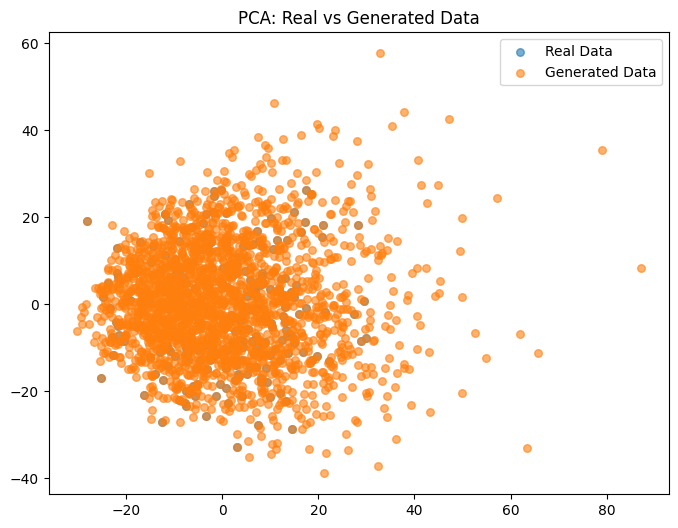

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


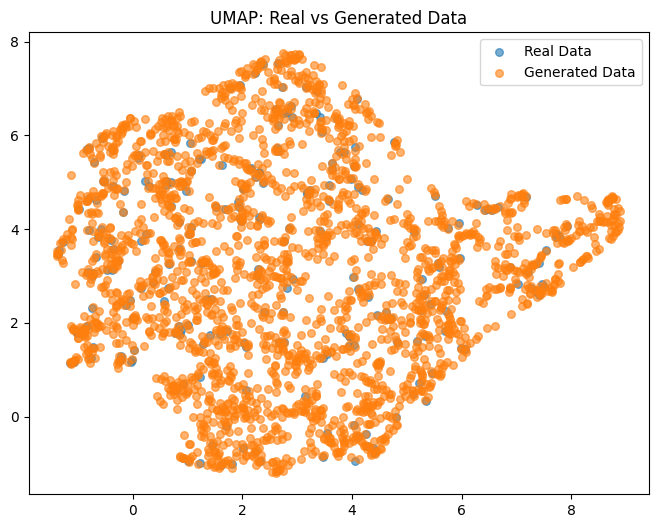

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap.umap_ as umap  # pip install umap-learn

# -----------------------------
# Prepare combined dataset
# -----------------------------
real_labels = np.zeros(len(df))       # 0 = real
gen_labels = np.ones(len(augmented_df)) # 1 = generated

combined = np.vstack([df, augmented_df])
labels = np.hstack([real_labels, gen_labels])

# -----------------------------
# PCA Visualization
# -----------------------------
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined)

plt.figure(figsize=(8,6))
plt.scatter(pca_result[labels==0, 0], pca_result[labels==0, 1],
            alpha=0.6, label="Real Data", s=30)
plt.scatter(pca_result[labels==1, 0], pca_result[labels==1, 1],
            alpha=0.6, label="Generated Data", s=30)
plt.title("PCA: Real vs Generated Data")
plt.legend()
plt.show()

# -----------------------------
# UMAP Visualization
# -----------------------------
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_result = reducer.fit_transform(combined)

plt.figure(figsize=(8,6))
plt.scatter(umap_result[labels==0, 0], umap_result[labels==0, 1],
            alpha=0.6, label="Real Data", s=30)
plt.scatter(umap_result[labels==1, 0], umap_result[labels==1, 1],
            alpha=0.6, label="Generated Data", s=30)
plt.title("UMAP: Real vs Generated Data")
plt.legend()
plt.show()


Mean WD: 0.026745082358444684
Median WD: 0.02349181083978867
Max WD: 0.18015668217944053
Min WD: 0.006891341073785069


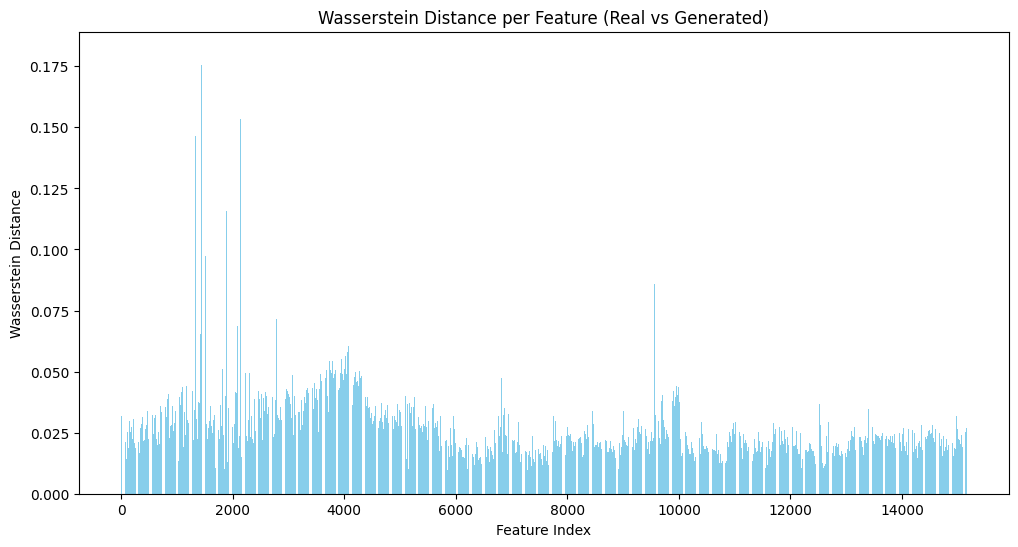

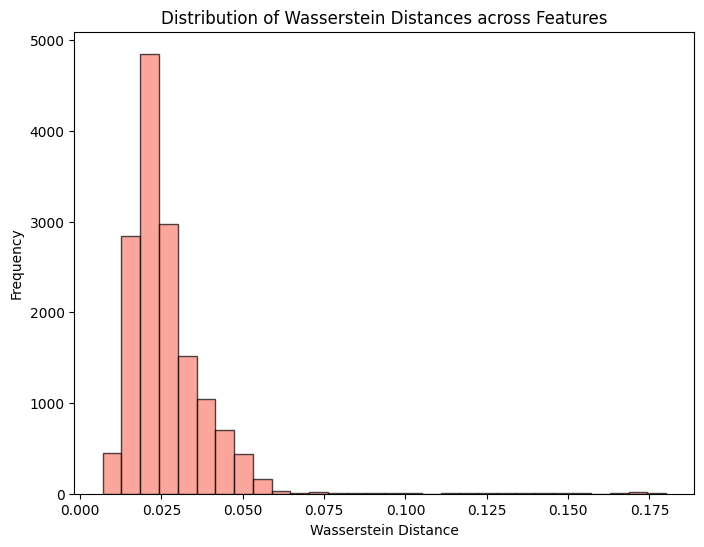

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

# Assume you already have:
# data -> original dataset (DataFrame)
# augmented_df -> generated dataset (DataFrame)

# Ensure both have the same shape (columns match)
assert df.shape[1] == augmented_df.shape[1], "Datasets must have same number of features"

# Compute Wasserstein distance per feature
distances = []
for col in range(df.shape[1]):
    real_col = df.iloc[:, col].values
    fake_col = augmented_df.iloc[:, col].values
    dist = wasserstein_distance(real_col, fake_col)
    distances.append(dist)

# Convert to DataFrame for analysis
wd_df = pd.DataFrame({
    "Feature": np.arange(1, df.shape[1]+1),
    "Wasserstein_Distance": distances
})

# Summary statistics
print("Mean WD:", np.mean(distances))
print("Median WD:", np.median(distances))
print("Max WD:", np.max(distances))
print("Min WD:", np.min(distances))

# Visualization
plt.figure(figsize=(12,6))
plt.bar(wd_df["Feature"], wd_df["Wasserstein_Distance"], color="skyblue")
plt.xlabel("Feature Index")
plt.ylabel("Wasserstein Distance")
plt.title("Wasserstein Distance per Feature (Real vs Generated)")
plt.show()

# Histogram of distances
plt.figure(figsize=(8,6))
plt.hist(distances, bins=30, color="salmon", edgecolor="black", alpha=0.7)
plt.xlabel("Wasserstein Distance")
plt.ylabel("Frequency")
plt.title("Distribution of Wasserstein Distances across Features")
plt.show()
